Epoch 1/50


c:\Users\nccoss\anaconda3\envs\f_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


380/380 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - accuracy: 0.6349 - loss: 1.1229 - val_accuracy: 0.7239 - val_loss: 0.5612 - learning_rate: 1.0000e-04
Epoch 2/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - accuracy: 0.7428 - loss: 0.5490 - val_accuracy: 0.7910 - val_loss: 0.4721 - learning_rate: 1.0000e-04
Epoch 3/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - accuracy: 0.7748 - loss: 0.5000 - val_accuracy: 0.7934 - val_loss: 0.5031 - learning_rate: 1.0000e-04
Epoch 4/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step - accuracy: 0.8108 - loss: 0.4364 - val_accuracy: 0.8427 - val_loss: 0.3519 - learning_rate: 1.0000e-04
Epoch 5/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - accuracy: 0.8392 - loss: 0.3744 - val_accuracy: 0.8302 - val_loss: 0.3589 - learning_rate: 1.0000e-04
Epoch 6/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - accuracy: 0.8579 - loss: 0.3262 - val_accuracy: 0.8871 - val_loss: 0.2500 - learning_rate: 1.0000e-04
Epoch 7/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - accurac

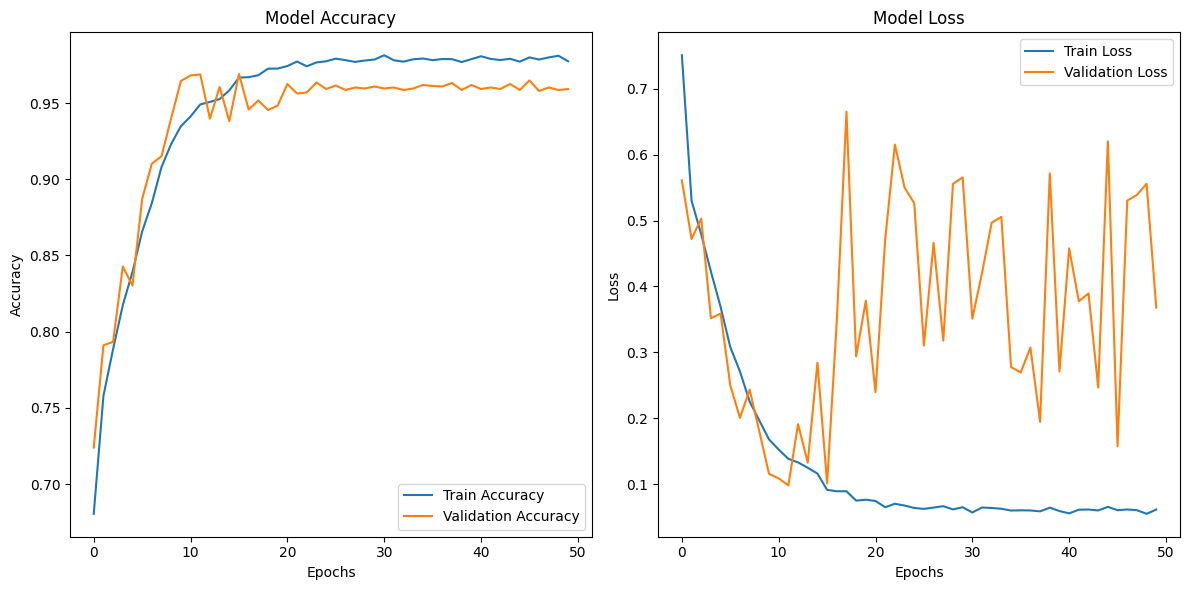

95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


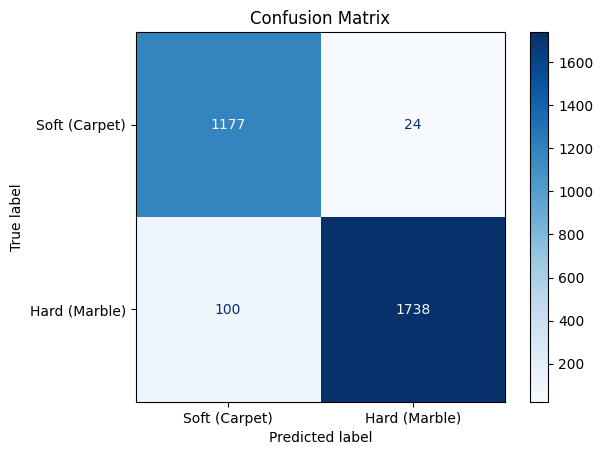

Classification Report:
               precision    recall  f1-score   support

Soft (Carpet)       0.92      0.98      0.95      1201
Hard (Marble)       0.99      0.95      0.97      1838

     accuracy                           0.96      3039
    macro avg       0.95      0.96      0.96      3039
 weighted avg       0.96      0.96      0.96      3039



In [1]:
import os
import numpy as np
import h5py
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input, Add
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from scipy.fft import fft2, fftshift
import matplotlib.pyplot as plt

# Function to load and process data (including additional features)
def process_frame_data(file_path, dataset_path):
    with h5py.File(file_path, 'r') as file:
        data = file[dataset_path][:]  # Extract the dataset
        real_part = data['real']
        imag_part = data['imag']

        # Apply 2D Fourier Transform
        f_transform_real = fft2(real_part)
        f_transform_imag = fft2(imag_part)
        f_transform_real_shifted = fftshift(f_transform_real)
        f_transform_imag_shifted = fftshift(f_transform_imag)

        # Compute magnitude spectrum
        mag_real = np.abs(f_transform_real_shifted)
        mag_imag = np.abs(f_transform_imag_shifted)

        # Compute log-transformed features
        log_mag_real = np.log1p(mag_real)
        log_mag_imag = np.log1p(mag_imag)

        # Combine features
        combined_features = np.stack([mag_real, mag_imag, log_mag_real, log_mag_imag], axis=-1)
    return combined_features

# Directory containing all the files
data_directory = r"C:\Users\nccoss\Desktop\캡디\바닥 재질\HARD"

X_data = []
y_labels = []

# Load all files in the directory
for file_name in os.listdir(data_directory):
    if file_name.endswith(".h5"):
        file_path = os.path.join(data_directory, file_name)
        label = 0 if "carpet" in file_name.lower() else 1  # Labeling: 0=Soft, 1=Hard
        try:
            processed_data = process_frame_data(file_path, 'session/group_0/entry_0/result/frame')
            X_data.append(processed_data)
            y_labels.extend([label] * len(processed_data))
        except Exception as e:
            print(f"Error processing file {file_name}: {e}")

# Convert lists to numpy arrays
X_data = np.concatenate(X_data, axis=0)
y_labels = np.array(y_labels)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_data, y_labels, test_size=0.2, random_state=42, stratify=y_labels)

# Normalize the data
X_train = X_train / 255.0
X_test = X_test / 255.0

# Convert labels to categorical format
y_train_categorical = to_categorical(y_train, num_classes=2)
y_test_categorical = to_categorical(y_test, num_classes=2)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)
datagen.fit(X_train)

# Define a more complex CNN model with Residual Connections
def build_model(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    # Residual Block 1
    residual = Conv2D(128, (1, 1), padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Add()([x, residual])  # Residual Connection
    x = MaxPooling2D((2, 2))(x)

    # Residual Block 2
    residual = Conv2D(256, (1, 1), padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Add()([x, residual])  # Residual Connection
    x = MaxPooling2D((2, 2))(x)

    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(2, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

# Build and compile the model
input_shape = X_train.shape[1:]
model = build_model(input_shape)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Train the model
history = model.fit(
    datagen.flow(X_train, y_train_categorical, batch_size=32),
    epochs=50,
    validation_data=(X_test, y_test_categorical),
    callbacks=[reduce_lr]
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test_categorical)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Save the model
model.save("floor_material_classifier_v2.keras")

# Function to plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues', values_format='d')
    plt.title('Confusion Matrix')
    plt.show()

# Function to print classification report
def print_classification_report(y_true, y_pred, class_names):
    print("Classification Report:")
    report = classification_report(y_true, y_pred, target_names=class_names)
    print(report)

# Plot training history
plot_training_history(history)

# Predict and evaluate
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_categorical, axis=1)

# Plot confusion matrix
class_names = ['Soft (Carpet)', 'Hard (Marble)']
plot_confusion_matrix(y_true_classes, y_pred_classes, class_names)

# Print classification report
print_classification_report(y_true_classes, y_pred_classes, class_names)


In [3]:
import numpy as np
import h5py
from tensorflow.keras.models import load_model

# 모델 로드
model = load_model("floor_material_classifier_v2.keras")  # 저장된 모델 이름

# 새로운 데이터 파일 경로
new_file_path = r"C:\Users\nccoss\Desktop\캡디\바닥 재질\HARD\carpet_2.h5"

# 새로운 데이터 처리 함수 (Fourier Transform 포함)
def process_new_file(file_path, dataset_path='session/group_0/entry_0/result/frame'):
    """
    Load and process data from an h5 file, including Fourier Transform.
    Returns a single frame processed to match the model input shape.
    """
    try:
        with h5py.File(file_path, 'r') as file:
            # Load the dataset
            data = file[dataset_path][0]  # 첫 번째 프레임만 선택
            real_part = data['real']
            imag_part = data['imag']

            # Apply 2D Fourier Transform
            f_transform_real = np.fft.fft2(real_part)
            f_transform_imag = np.fft.fft2(imag_part)
            f_transform_real_shifted = np.fft.fftshift(f_transform_real)
            f_transform_imag_shifted = np.fft.fftshift(f_transform_imag)

            # Compute Magnitude Spectrum
            mag_real = np.abs(f_transform_real_shifted)
            mag_imag = np.abs(f_transform_imag_shifted)
            log_mag_real = np.log1p(mag_real)
            log_mag_imag = np.log1p(mag_imag)

            # Combine features into a single array
            combined_features = np.stack([mag_real, mag_imag, log_mag_real, log_mag_imag], axis=-1)

        return combined_features

    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return None

# 데이터 처리
new_data = process_new_file(new_file_path)
if new_data is None:
    print("데이터를 처리하는 중 오류가 발생했습니다.")
else:
    # 데이터 정규화
    new_data = new_data / 255.0

    # 모델에 입력 가능한 형태로 차원 조정 (배치 차원 추가)
    new_data = np.expand_dims(new_data, axis=0)  # (1, 32, 40, 4)

    # 예측
    prediction = model.predict(new_data)
    predicted_label = np.argmax(prediction, axis=1)

    # 예측 결과 출력
    if predicted_label[0] == 0:
        print("Soft")
    else:
        print("Hard")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
Soft


In [2]:
from tensorflow.keras.models import load_model

# 저장된 모델 불러오기
model = load_model("floor_material_classifier_v2.keras")

model.summary()  # 모델 구조 출력


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 40, 4) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 40,    │      2,368 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32, 40,    │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 16, 20,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 16, 20,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 20,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 16, 20,    │      8,320 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 16, 20,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 8, 10,     │          0 │ add[0][0]         │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 8, 10,     │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 10,     │      1,024 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 8, 10,     │     33,024 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 8, 10,     │          0 │ batch_normalizat… │
│                     │ 256)              │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 4, 5, 256) │          0 │ add_1[0][0]       │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 5120)      │          0 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │    655,488 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 2)         │        258 │ dropout[0][0]   

 Total params: 3,209,032 (12.24 MB)

 Trainable params: 1,069,378 (4.08 MB)

 Non-trainable params: 896 (3.50 KB)

 Optimizer params: 2,138,758 (8.16 MB)